In [ ]:
!pip install entsoe

In [9]:
import pandas as pd
from entsoe import EntsoePandasClient
import os

# Initialize the ENTSOE client with your API token
ENTSOE_API_KEY = os.environ["ENTSOE_API_KEY"]
client = EntsoePandasClient(api_key=ENTSOE_API_KEY)

def download_entsoe_total_load(
    start_date: str, 
    end_date: str, 
    country_code: str, 
    timezone: str = "Europe/Brussels",
) -> pd.DataFrame:
    """Downloads the hourly day ahead forecast and actual load from the ENTSOE transparency platform using entsoe-py.

    Args:
        start_date: Start date in the format YYYY-MM-DD.
        end_date: End date in the format YYYY-MM-DD.
        country_code: ISO code of the country.
        timezone: Timezone of the country.

    Returns:
        A DataFrame containing both Hourly Day Ahead Forecast and Actual Total Load.
    """

    # Query Day-Ahead Load Forecast (returns a DataFrame)
    load_forecast = client.query_load_forecast(
        country_code, 
        start=pd.Timestamp(start_date, tz=timezone), 
        end=pd.Timestamp(end_date, tz=timezone)
    )
    
    # Query Actual Load (returns a DataFrame)
    actual_load = client.query_load(
        country_code, 
        start=pd.Timestamp(start_date, tz=timezone), 
        end=pd.Timestamp(end_date, tz=timezone)
    )

    # Reset index and convert timestamps to UTC for consistency
    load_forecast = load_forecast.reset_index()
    actual_load = actual_load.reset_index()

    load_forecast['timestamp'] = load_forecast['index'].dt.tz_convert('UTC')
    actual_load['timestamp'] = actual_load['index'].dt.tz_convert('UTC')

    # Drop the old index columns
    load_forecast = load_forecast.drop(columns=['index'])
    actual_load = actual_load.drop(columns=['index'])

    # Merge the forecast and actual load data on the timestamp
    load_df = pd.merge(load_forecast, actual_load, on='timestamp', how='outer', suffixes=('_forecast', '_actual'))

    # Set the timestamp as the index and resample to hourly data
    load_df.set_index('timestamp', inplace=True)
    load_df = load_df.resample('H').mean()  # Resample to hourly, taking the mean

    return load_df.reset_index()


In [12]:
# Download the total load data you are interested in
load_df_belgium = download_entsoe_total_load(start_date="2015-01-01", end_date="2023-12-31" , country_code="BE")
load_df_belgium.to_parquet("/work/entsoe/total_load_belgium.parquet")
load_df_belgium


,timestamp,Forecasted Load,Actual Load
0,2014-12-31 23:00:00+00:00,9452.25,9992.00
1,2015-01-01 00:00:00+00:00,9955.25,9552.00
2,2015-01-01 01:00:00+00:00,9521.00,9151.75
3,2015-01-01 02:00:00+00:00,9134.75,8798.50
4,2015-01-01 03:00:00+00:00,8909.00,8567.00
...,...,...,...
78859,2023-12-30 18:00:00+00:00,9571.75,8956.50
78860,2023-12-30 19:00:00+00:00,9166.00,8555.25
78861,2023-12-30 20:00:00+00:00,8764.00,8207.50
78862,2023-12-30 21:00:00+00:00,8768.75,8131.50


In [20]:
(lambda: DeepnoteChart(load_df_belgium, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}""") if 'DeepnoteChart' in globals() else _dntk.DeepnoteChart(load_df_belgium, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}"""))()

In [13]:
load_df_germany = download_entsoe_total_load(start_date="2015-01-01", end_date="2023-12-31" , country_code="DE")
load_df_germany.to_parquet("/work/entsoe/total_load_germany.parquet")
load_df_germany


,timestamp,Forecasted Load,Actual Load
0,2014-12-31 23:00:00+00:00,42155.75,45000.50
1,2015-01-01 00:00:00+00:00,39969.50,43833.25
2,2015-01-01 01:00:00+00:00,38813.00,42322.25
3,2015-01-01 02:00:00+00:00,38490.00,40966.00
4,2015-01-01 03:00:00+00:00,38643.75,40283.50
...,...,...,...
78859,2023-12-30 18:00:00+00:00,51643.25,51672.00
78860,2023-12-30 19:00:00+00:00,49294.75,48793.50
78861,2023-12-30 20:00:00+00:00,47011.50,46169.00
78862,2023-12-30 21:00:00+00:00,45925.25,44365.50


In [23]:
(lambda: DeepnoteChart(load_df_germany, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}""") if 'DeepnoteChart' in globals() else _dntk.DeepnoteChart(load_df_germany, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}"""))()

In [14]:
load_df_denmark = download_entsoe_total_load(start_date="2015-01-01", end_date="2023-12-31" , country_code="DK")
load_df_denmark.to_parquet("/work/entsoe/total_load_denmark.parquet")
load_df_denmark

,timestamp,Forecasted Load,Actual Load
0,2014-12-31 23:00:00+00:00,3324.0,3286.0
1,2015-01-01 00:00:00+00:00,3244.0,3211.0
2,2015-01-01 01:00:00+00:00,3127.0,3100.0
3,2015-01-01 02:00:00+00:00,3019.0,2980.0
4,2015-01-01 03:00:00+00:00,2976.0,2933.0
...,...,...,...
78859,2023-12-30 18:00:00+00:00,4304.0,4328.0
78860,2023-12-30 19:00:00+00:00,4158.0,4200.0
78861,2023-12-30 20:00:00+00:00,4065.0,4091.0
78862,2023-12-30 21:00:00+00:00,3915.0,3936.0


In [27]:
(lambda: DeepnoteChart(load_df_denmark, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}""") if 'DeepnoteChart' in globals() else _dntk.DeepnoteChart(load_df_denmark, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}"""))()

In [15]:
load_df_netherlands = download_entsoe_total_load(start_date="2015-01-01", end_date="2023-12-31" , country_code="NL")
load_df_netherlands.to_parquet("/work/entsoe/total_load_netherlands.parquet")
load_df_netherlands

,timestamp,Forecasted Load,Actual Load
0,2014-12-31 23:00:00+00:00,9782.00,9794.00
1,2015-01-01 00:00:00+00:00,9011.50,9456.00
2,2015-01-01 01:00:00+00:00,8607.75,8956.75
3,2015-01-01 02:00:00+00:00,8461.75,8461.50
4,2015-01-01 03:00:00+00:00,8499.50,8156.00
...,...,...,...
78859,2023-12-30 18:00:00+00:00,12561.75,13645.00
78860,2023-12-30 19:00:00+00:00,12303.25,13305.75
78861,2023-12-30 20:00:00+00:00,11870.75,12910.50
78862,2023-12-30 21:00:00+00:00,11471.75,12467.00


In [30]:
(lambda: DeepnoteChart(load_df_netherlands, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}""") if 'DeepnoteChart' in globals() else _dntk.DeepnoteChart(load_df_netherlands, """{"layer":[{"layer":[{"mark":{"clip":true,"type":"circle","color":"#2266D3","tooltip":true},"encoding":{"x":{"axis":{"grid":false},"sort":"ascending","type":"temporal","field":"timestamp","scale":{"type":"linear","zero":false}},"y":{"axis":{"grid":false},"sort":null,"type":"quantitative","field":"Actual Load","scale":{"type":"linear","zero":false},"format":{"type":"default","decimals":null},"formatType":"numberFormatFromNumberType"}}}]}],"title":"","config":{"legend":{}},"$schema":"https://vega.github.io/schema/vega-lite/v5.json","encoding":{},"usermeta":{"tooltipDefaultMode":true}}"""))()

In [ ]:
##Heatmaps

In [1]:
# load the data
import pandas as pd

load_df_netherlands = pd.read_parquet("/work/entsoe/total_load_netherlands.parquet")
load_df_belgium = pd.read_parquet("/work/entsoe/total_load_belgium.parquet")
load_df_denmark = pd.read_parquet("/work/entsoe/total_load_denmark.parquet")
load_df_germany = pd.read_parquet("/work/entsoe/total_load_germany.parquet")

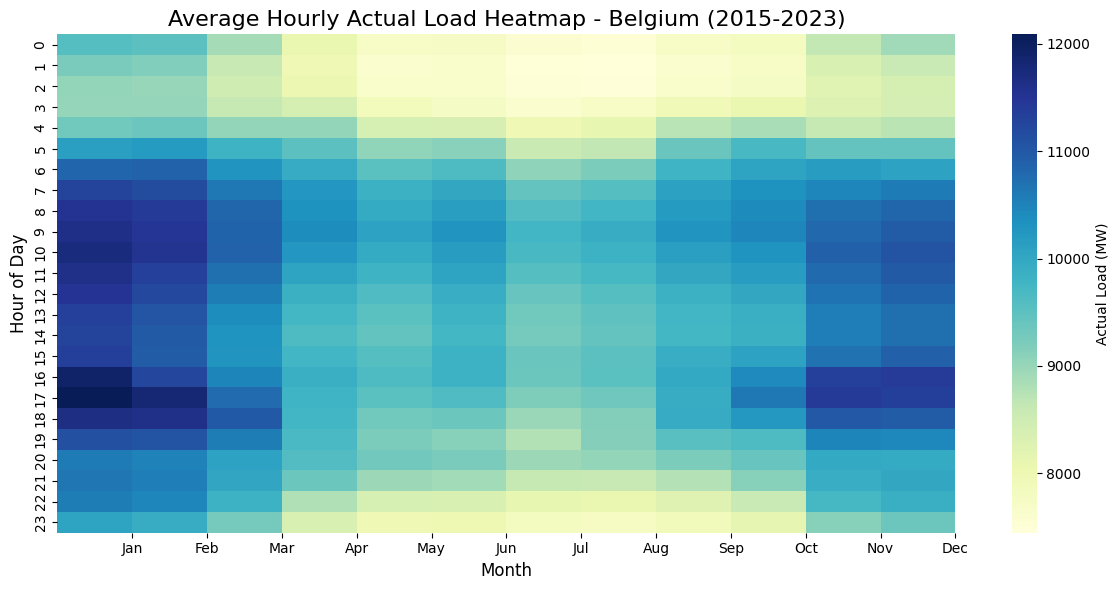

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming load_df_belgium is your DataFrame with 'timestamp' and 'Actual Load' columns

# Step 1: Convert 'timestamp' to datetime if not already done
load_df_belgium['timestamp'] = pd.to_datetime(load_df_belgium['timestamp'])

# Step 2: Extract the hour and month from the 'timestamp'
load_df_belgium['hour'] = load_df_belgium['timestamp'].dt.hour
load_df_belgium['month'] = load_df_belgium['timestamp'].dt.month

# Step 3: Group by month and hour, calculating the mean actual load
load_hourly_avg = load_df_belgium.groupby(['month', 'hour'])['Actual Load'].mean().reset_index()

# Step 4: Pivot the data to have hours as rows and months as columns
heatmap_data = load_hourly_avg.pivot(index='hour', columns='month', values='Actual Load')

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Actual Load (MW)'})

# Customize the plot
plt.title('Average Hourly Actual Load Heatmap - Belgium (2015-2023)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)

# Set custom x-tick labels for months (1-12 -> Jan-Dec)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()


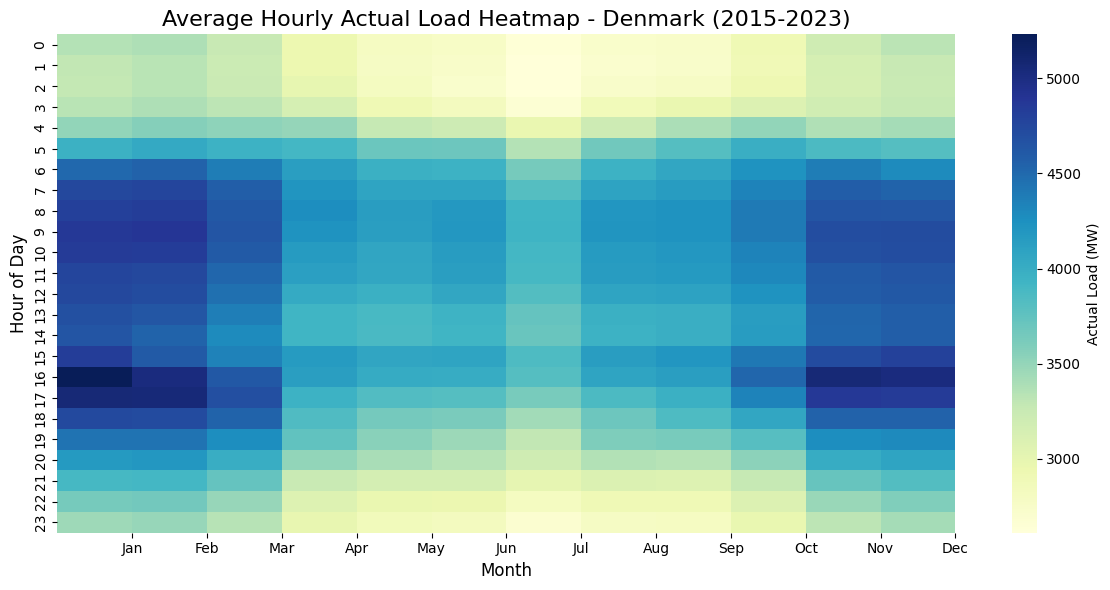

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming load_df_denmark is your DataFrame with 'timestamp' and 'Actual Load' columns

# Step 1: Convert 'timestamp' to datetime if not already done
load_df_denmark['timestamp'] = pd.to_datetime(load_df_denmark['timestamp'])

# Step 2: Extract the hour and month from the 'timestamp'
load_df_denmark['hour'] = load_df_denmark['timestamp'].dt.hour
load_df_denmark['month'] = load_df_denmark['timestamp'].dt.month

# Step 3: Group by month and hour, calculating the mean actual load
load_hourly_avg = load_df_denmark.groupby(['month', 'hour'])['Actual Load'].mean().reset_index()

# Step 4: Pivot the data to have hours as rows and months as columns
heatmap_data = load_hourly_avg.pivot(index='hour', columns='month', values='Actual Load')

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Actual Load (MW)'})

# Customize the plot
plt.title('Average Hourly Actual Load Heatmap - Denmark (2015-2023)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)

# Set custom x-tick labels for months (1-12 -> Jan-Dec)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()


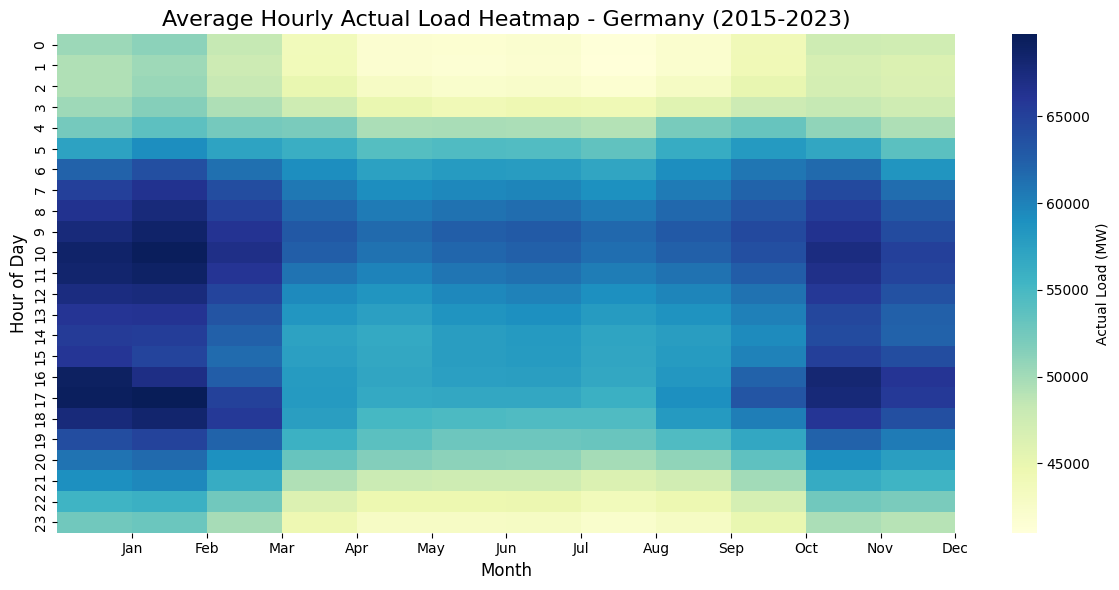

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming load_df_germany is your DataFrame with 'timestamp' and 'Actual Load' columns

# Step 1: Convert 'timestamp' to datetime if not already done
load_df_germany['timestamp'] = pd.to_datetime(load_df_germany['timestamp'])

# Step 2: Extract the hour and month from the 'timestamp'
load_df_germany['hour'] = load_df_germany['timestamp'].dt.hour
load_df_germany['month'] = load_df_germany['timestamp'].dt.month

# Step 3: Group by month and hour, calculating the mean actual load
load_hourly_avg = load_df_germany.groupby(['month', 'hour'])['Actual Load'].mean().reset_index()

# Step 4: Pivot the data to have hours as rows and months as columns
heatmap_data = load_hourly_avg.pivot(index='hour', columns='month', values='Actual Load')

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Actual Load (MW)'})

# Customize the plot
plt.title('Average Hourly Actual Load Heatmap - Germany (2015-2023)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)

# Set custom x-tick labels for months (1-12 -> Jan-Dec)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()


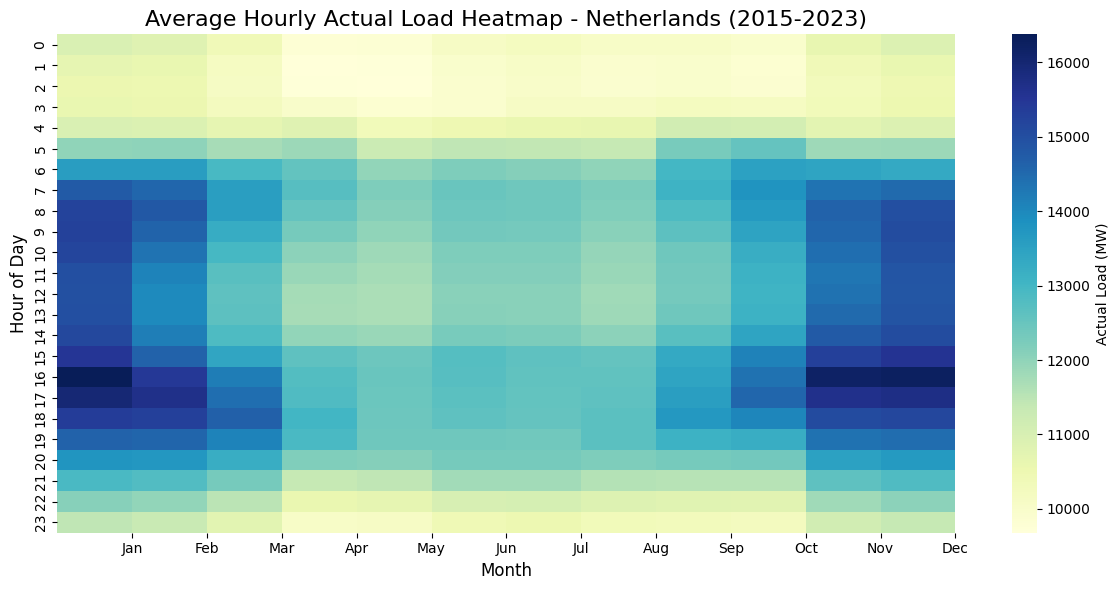

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming load_df_netherlands is your DataFrame with 'timestamp' and 'Actual Load' columns

# Step 1: Convert 'timestamp' to datetime if not already done
load_df_netherlands['timestamp'] = pd.to_datetime(load_df_netherlands['timestamp'])

# Step 2: Extract the hour and month from the 'timestamp'
load_df_netherlands['hour'] = load_df_netherlands['timestamp'].dt.hour
load_df_netherlands['month'] = load_df_netherlands['timestamp'].dt.month

# Step 3: Group by month and hour, calculating the mean actual load
load_hourly_avg = load_df_netherlands.groupby(['month', 'hour'])['Actual Load'].mean().reset_index()

# Step 4: Pivot the data to have hours as rows and months as columns
heatmap_data = load_hourly_avg.pivot(index='hour', columns='month', values='Actual Load')

# Step 5: Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=False, cbar_kws={'label': 'Actual Load (MW)'})

# Customize the plot
plt.title('Average Hourly Actual Load Heatmap - Netherlands (2015-2023)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Hour of Day', fontsize=12)

# Set custom x-tick labels for months (1-12 -> Jan-Dec)
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Show the plot
plt.tight_layout()
plt.show()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=c6d312a4-2fad-4555-a64a-cb89f1604b41' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>